# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import pickle
import tensorflow as tf
import gp_gpy as gp
import plot 

sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_pickle('train.pkl')
n_segs = data.seg.unique()
synch_traj_n = 7 # traj 7 was used to train synch gps
route_n = 3 # all data used currently is from route 3
data.head()

,lat,lon,traj,seg,speed,time_left,progress
1026,15.564899,58.414535,3.0,2,3.75,47.0,0.000000
1027,15.564623,58.414406,3.0,2,-1.00,40.0,0.027778
1028,15.564840,58.414499,3.0,2,3.65,36.0,0.055556
1029,15.564685,58.414433,3.0,2,4.01,33.0,0.083333
1030,15.564623,58.414406,3.0,2,4.37,32.0,0.111111


## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [2]:
def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(latlon, axis=1)
    return synched_data
  
def train_gps(seg_n):
    seg = traj[traj.seg == seg_n]
    synch_gp = gp.load_synch(route_n, seg_n)
    synched_seg = synch_data(synch_gp, seg)
    n_restarts = 5
    
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg, 
        ['tau'],
        ['lat', 'lon'],
        'likelihood-v1',
        route_n, 
        traj_n, 
        seg_n)
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg, 
        ['tau'], 
        ['time_left'], 
        'predict-v1', 
        route_n, 
        traj_n, 
        seg_n)    
    gp.train(prediction_model, n_restarts)
    return likelihood_model, prediction_model


n_trajs = data.traj.unique()
traj_n = n_trajs[0]
traj = data[data.traj == traj_n]
print(traj)
gp_tuples = [train_gps(seg_n) for seg_n in n_segs]

            lat        lon  traj  seg  speed  time_left  progress
1026  15.564899  58.414535   3.0    2   3.75       47.0  0.000000
1027  15.564623  58.414406   3.0    2  -1.00       40.0  0.027778
1028  15.564840  58.414499   3.0    2   3.65       36.0  0.055556
1029  15.564685  58.414433   3.0    2   4.01       33.0  0.083333
1030  15.564623  58.414406   3.0    2   4.37       32.0  0.111111
1031  15.564520  58.414364   3.0    2   6.17       31.0  0.138889
1032  15.564430  58.414326   3.0    2   6.58       30.0  0.166667
1033  15.564328  58.414288   3.0    2   6.99       29.0  0.194444
1034  15.564221  58.414249   3.0    2   7.45       28.0  0.222222
1035  15.564115  58.414204   3.0    2   7.97       27.0  0.250000
1036  15.563996  58.414158   3.0    2   8.38       26.0  0.277778
1037  15.563874  58.414108   3.0    2   8.79       25.0  0.305556
1038  15.563745  58.414062   3.0    2   9.05       24.0  0.333333
1039  15.563616  58.414013   3.0    2   9.36       23.0  0.361111
1040  15.5

Optimization restart 3/5, f = 106.57654476739924
Optimization restart 4/5, f = 106.57654476748998
Optimization restart 5/5, f = 106.57654476840814
Optimization restart 1/5, f = -700.6860785345766
Optimization restart 2/5, f = -700.6863042887412
Optimization restart 3/5, f = -700.6861989232618
Optimization restart 4/5, f = -700.6863098827343
Optimization restart 5/5, f = -700.6860569891705
Optimization restart 1/5, f = 87.7585580306463
Optimization restart 2/5, f = 87.75855803065136
Optimization restart 3/5, f = 87.758558030754
Optimization restart 4/5, f = 87.75855803078338
Optimization restart 5/5, f = 87.75855803373517


Let's plot some of the GPs to see what they look like

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


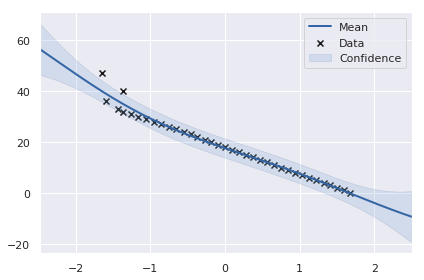

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


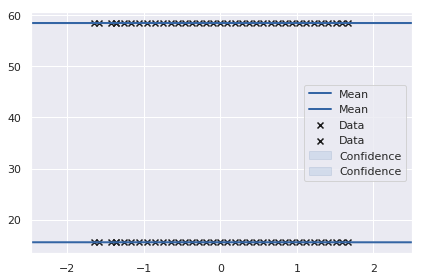

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


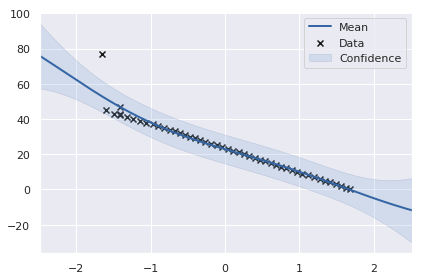

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


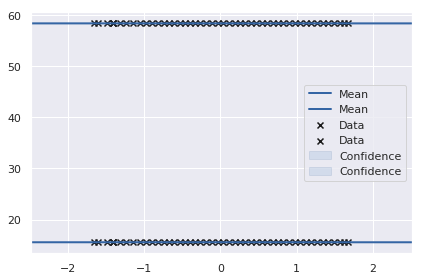

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


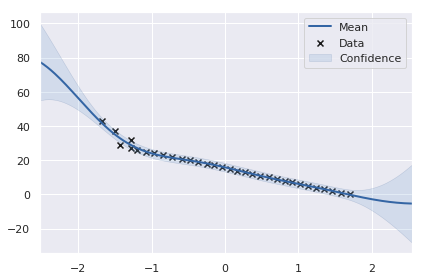

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


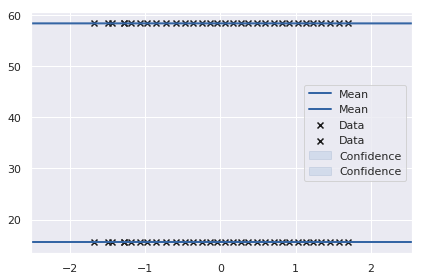

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


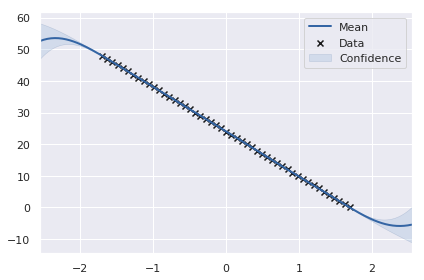

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


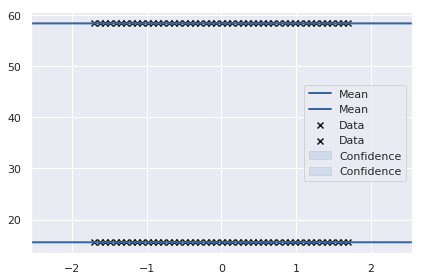

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


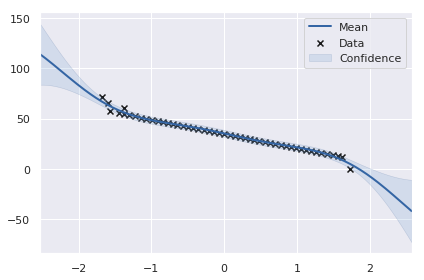

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


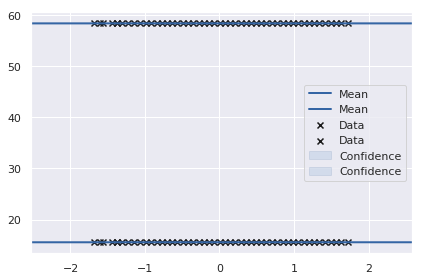

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


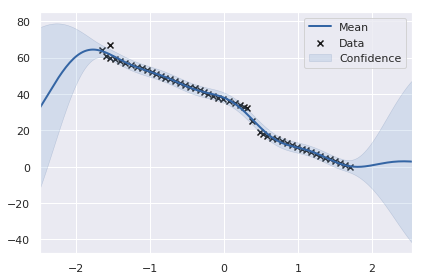

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


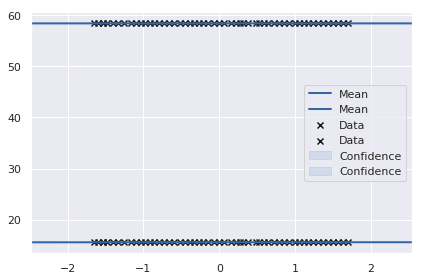

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


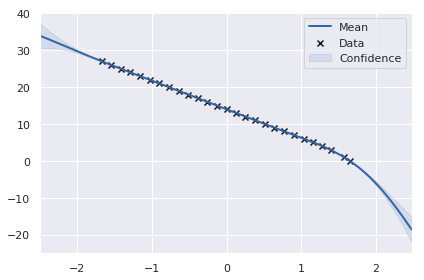

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


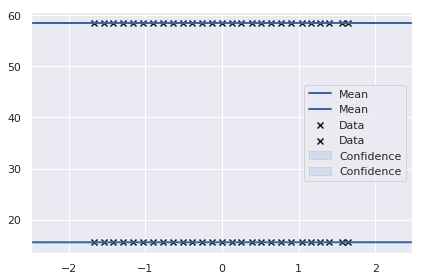

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


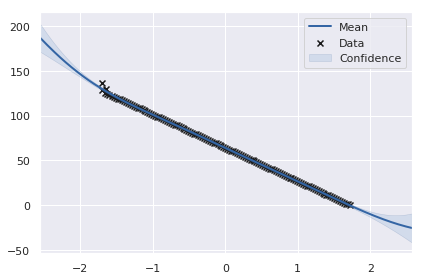

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


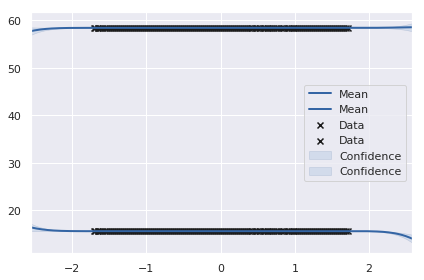

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


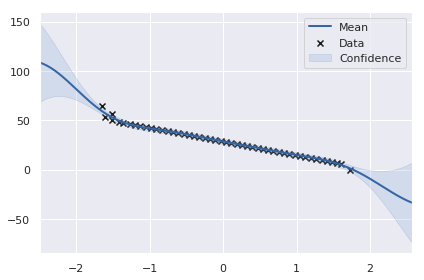

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


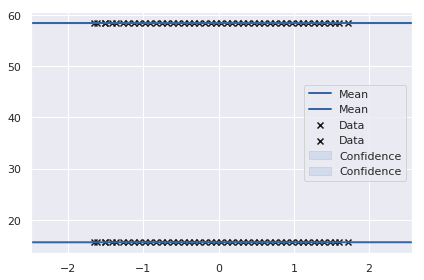

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


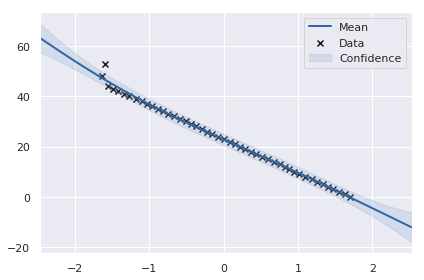

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


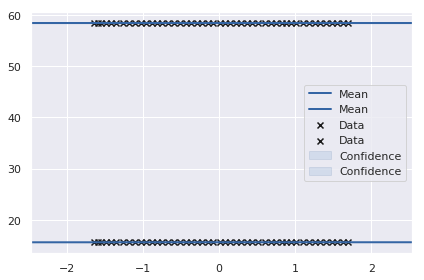

In [3]:
for lik_model, pred_model in gp_tuples:
    gp.plot(pred_model)
    gp.plot(lik_model)

The results for the prediction plots look really good, the ones for the likelihood is a bit harder to interpret. We'll save both do disk though.

In [4]:
for lik_model, pred_model in gp_tuples:
    gp.save(lik_model)
    gp.save(pred_model)

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

In [7]:

def predict(traj, synch_gp, route_n, seg_n):
    synched_traj = synch_data(synch_gp, traj)
    models = gp.load_trajs('predict', route_n, seg_n)
    models_by_prob = most_likely_models(synched_traj, models)
    
    return models_by_prob

def most_likely_models(synched_traj, models):    
    def mk_model(m): 
        model = gp.build(synched_traj, ['tau'], ['lat', 'lon'], '', route_n, 0, seg_n)
        return gp.set_params(model, m.model.param_array)
    
    models_with_this_traj = [mk_model(m) for m in models]
    sorted_models = sorted(models_with_this_traj, key=gp.loglik, reverse=True)
    return [(m, np.exp(gp.loglik(m))) for m in sorted_models]

test = pd.read_pickle('test.pkl')
n_test_trajs = test.traj.unique()
n_test_segs = test.seg.unique()
seg_n = n_test_segs[0]
test_seg = test[(test.traj == n_test_trajs[0]) & (test.seg == seg_n)]
synch_gp = gp.load_synch(route_n, seg_n)
predict(test_seg, synch_gp, route_n, seg_n)

#predictions = [predict(learned_params, synch_gps, test_trajs[test_trajs.traj == traj_n]) for traj_n in n_test_trajs]


[(GP(model=<GPy.models.gp_regression.GPRegression object at 0x7f2b551902b0>, X=array([[-1.61304799],
         [-1.44359629],
         [-1.15678149],
         [-1.39583974],
         [-1.30189554],
         [-1.23584667],
         [-1.15678149],
         [-1.06817252],
         [-0.97231093],
         [-0.87117255],
         [-0.77611651],
         [-0.68418768],
         [-0.59227682],
         [-0.49965546],
         [-0.40536135],
         [-0.31768618],
         [-0.23148267],
         [-0.14178311],
         [-0.04992153],
         [ 0.04154585],
         [ 0.13367859],
         [ 0.2234912 ],
         [ 0.31733969],
         [ 0.40856345],
         [ 0.50420764],
         [ 0.59910892],
         [ 0.69794641],
         [ 0.79534846],
         [ 0.88830062],
         [ 0.98128985],
         [ 1.08524812],
         [ 1.19000243],
         [ 1.31512297],
         [ 1.44610016],
         [ 1.59623336],
         [ 1.75737132],
         [ 1.93301747]]), Y=array([[15.56506157, 58.4145965